In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,desc
from sqlalchemy import Column, Integer,String, Float,Table,ForeignKey, Date


In [5]:
# reflect an existing database into a new model
Base = automap_base()


In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
conn = engine.connect()

In [8]:
# reflect the tables
Base.prepare(engine,reflect=True)

In [9]:
#print all the classes to reflect the database tables
Base.classes.keys()

['measurement', 'station']

In [10]:
# We can view all of the classes that automap found
Station = Base.classes.station
Measurement = Base.classes.measurement


In [11]:
# create a session
session = Session(engine)


In [12]:
# Save references to each table
Base.prepare(engine,reflect=True)

/usr/local/anaconda3/lib/python3.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)
/usr/local/anaconda3/lib/python3.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


In [13]:
# Create our session (link) from Python to the DB


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Calculate the date 1 year ago from the last data point in the database
#filter the 12 months of preciptation data

results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>='2016-08-23',
                                         ).filter(Measurement.date<='2017-08-22')


In [15]:
# Perform a query to retrieve the data and precipitation scores
date= [results[2] for result in results[:]]
scores = [results[3] for result in results[:]]

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(results[:],columns = ['Measurement.date','Measurement.prcp'])

df_prcp = df.sort_values(by='Measurement.date',ascending=True)
df_scores = df_prcp.set_index('Measurement.date')

df_scores

,Measurement.prcp
Measurement.date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-21,0.02
2017-08-21,0.00
2017-08-22,0.00


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


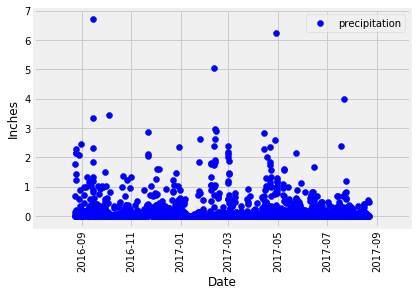

In [17]:
#Plot the results using the DataFrame plot method.
dates = df_scores.index
Inches = df_scores['Measurement.prcp']
dates = [pd.to_datetime(d) for d in dates]
plt.xticks(rotation=90)
plt.scatter(dates,Inches,c='blue')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'])
fig = plt.show()


In [18]:
#Use Pandas to print the summary statistics for the precipitation data.
print(df_scores.describe())

       Measurement.prcp
count       2017.000000
mean           0.177367
std            0.461568
min            0.000000
25%            0.000000
50%            0.020000
75%            0.130000
max            6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f'There are in total {station_count} stations available in this dataset')

There are in total 9 stations available in this dataset


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).statement
df_active_station = pd.read_sql_query(active_station,session.bind)
df_active_station = df_active_station.sort_values(by='count_1',ascending=False)
most_active_station = df_active_station['count_1'].max()
print(f'The most active station is USC00519281- {most_active_station} rows')
df_active_station

The most active station is USC00519281- 2772 rows


,station,count_1
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [21]:
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>='2016-08-23',
                                         ).filter(Measurement.date<='2017-08-22')

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#filter the query
#option 1
query_most_active_station = session.query(Measurement.station,Measurement.tobs).filter(Measurement.station== 'USC00519281').statement

#convert sql query to dataframe
df_query_most_active_station = pd.read_sql_query(query_most_active_station,session.bind)
max = df_query_most_active_station['tobs'].max()
min = df_query_most_active_station['tobs'].min()
mean = round(df_query_most_active_station['tobs'].mean(),2)
print(f'Highest temperature recorded for the most active station is {max}')
print(f'Lowest temperature recorded for the most active station is {min}')
print(f'Average temperature recorded for the most active station is {mean}')

Highest temperature recorded for the most active station is 85.0
Lowest temperature recorded for the most active station is 54.0
Average temperature recorded for the most active station is 71.66


In [24]:
#Option 2 by using func.min, func.max, func.avg, and func.count in the queries
query_max_temp_in_most_active_station = session.query(Measurement.station,func.max(Measurement.tobs),
                                                      func.min(Measurement.tobs),func.avg(Measurement.tobs)
                                                     ).filter(Measurement.station=='USC00519281').statement
#convert to df
df_query_max_temp_in_most_active_station = pd.read_sql_query(query_max_temp_in_most_active_station,session.bind)

max1 = df_query_max_temp_in_most_active_station['max_1']
min1 = df_query_max_temp_in_most_active_station['min_1']
avg = df_query_max_temp_in_most_active_station['avg_1']
print(f'Highest temperature recorded for the most active station is {max1}')
print(f'Lowest temperature recorded for the most active station is {min1}')
print(f'Average temperature recorded for the most active station is {avg}')


Highest temperature recorded for the most active station is 0    85.0
Name: max_1, dtype: float64
Lowest temperature recorded for the most active station is 0    54.0
Name: min_1, dtype: float64
Average temperature recorded for the most active station is 0    71.663781
Name: avg_1, dtype: float64


In [25]:
# Choose the station with the highest number of temperature observations.

query_highest_temp_station = session.query(Measurement.station, 
                                           func.count(Measurement.tobs)).group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).limit(1).statement

df_query_highest_temp_station = pd.read_sql_query(query_highest_temp_station,session.bind)
highest_num_station = df_query_highest_temp_station["station"]
print(f'The station with the highest number of temperature observations is {highest_num_station}')

query_12_months = session.query(Measurement.tobs).filter(Measurement.date>='2016-08-23',
                                         ).filter(Measurement.date<='2017-08-22').filter(Measurement.station=='USC00519281').statement

df_query_12_months= pd.read_sql_query(query_12_months,session.bind)
df_query_12_months

The station with the highest number of temperature observations is 0    USC00519281
Name: station, dtype: object


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


Text(0, 0.5, 'Frequency')

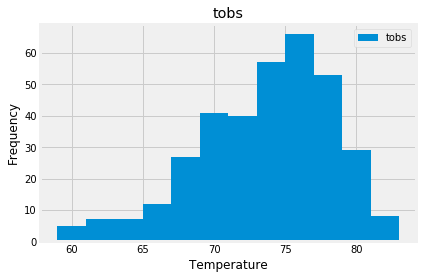

In [26]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_query_12_months.hist(column='tobs',bins=12,label="tobs")
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("Frequency")

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
